In [2]:
import numpy as np
import pandas as pd
import skimage.io as sio
import matplotlib.pyplot as plt

import diff_classifier.aws as aws
import diff_register.register as reg
import diff_register.im_process as imp

c:\users\enuser\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


One of the key features of diff_register is extracting cellular properties from input images. This demo notebook will show how to extract cellular properties without incorporating any accompanying multi-particle tracking datasets.

As an example dataset, I have included a large tif image of a DAPI stain in a brain slice from which we would like to extract cellular features. As DAPI stains cell nuclei, and cell nuclei are round, the resulting branch/process features won't be very informative, but users can see how they would be used

In [3]:
cprefix = 'P10_LPS_Iba_tilescan-MaxIP_R_thal'
cfile = 'C:/Users/enuser/Desktop/P01/{}.tif'.format(cprefix)
newprefix = 'P10_LPS_R_thal_DAPI'
newfile = '{}.tif'.format(newprefix)
#cfolder = 'Tissue_Studies/04_23_18_Registration_Test'

#aws.download_s3('{}/{}'.format(cfolder, cfile), cfile, bucket_name='ccurtis.data')

cim = sio.imread(cfile)

pxrat_cells = 1.24
#pxrat_traj = 0.16
#dim_traj = 2048
#dim_cells = int(np.round(dim_traj*pxrat_traj/pxrat_cells, decimals=0))

In [392]:
cimm = cim[0,:,:]

Users can use the skimage.io toolbox to preview the image. This tilescan image is fairly large. If users want to view a subset of the image, they can use the indices of the image to zoom in.

c:\users\enuser\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


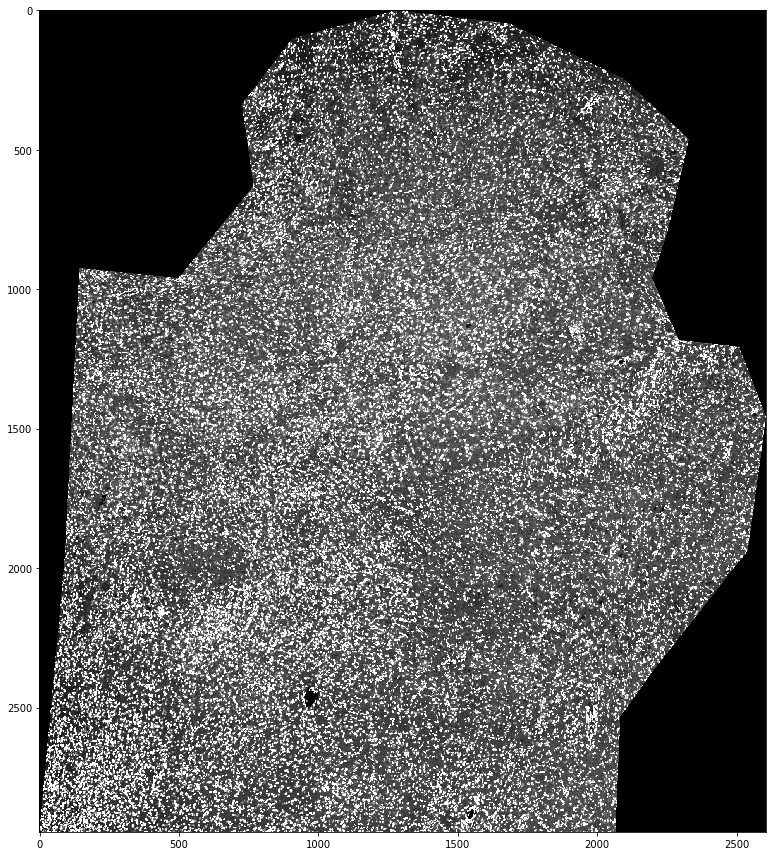

In [393]:
plt.subplots(figsize=(12,12))
sio.imshow(cimm, vmin=60, vmax=2500, cmap='gray')

In [394]:
sio.imsave(newfile, cimm)

diff_register can be run directly on large tilescans, but it is a good idea to optimize image processing parameters on a smaller image first. Try running skeleton_image on the small image from above.

c:\users\enuser\anaconda3\lib\site-packages\skimage\util\dtype.py:118: UserWarning: Possible sign loss when converting negative image of type int32 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
c:\users\enuser\anaconda3\lib\site-packages\skimage\util\dtype.py:171: UserWarning: Downcasting int32 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


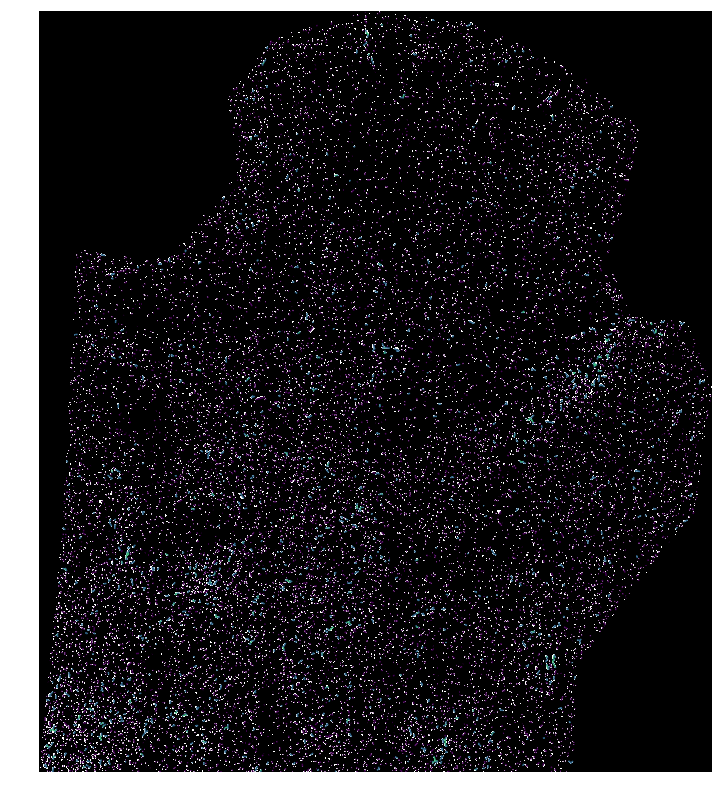

In [395]:
skel = imp.skeleton_image('.', newfile, 220, 5, tofilt=True, show=True, imname='skel_{}'.format(newfile),
                   channel=None, figsize=(14,14), ajar=False, close=False)

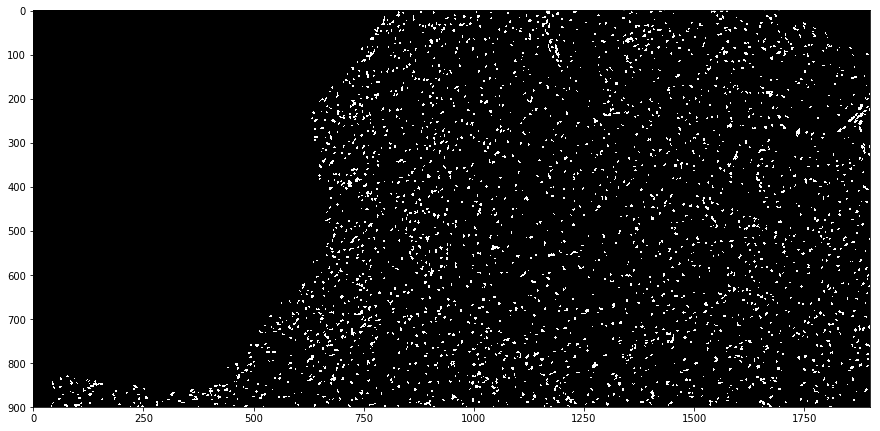

In [396]:
plt.subplots(figsize=(15,15))
plt.imshow(skel.shortim[100:1000, 100:2000], cmap='gray')

In [397]:
Dfeatures = imp.mglia_features(skel, umppx=1.24)

In [398]:
Dfeatures.describe()

,X,Y,area,average_branch,eccentricity,label,main_branch,perimeter,solidity,total_branches
count,16316.000000,16316.000000,16316.000000,16316.000000,16316.000000,16316.000000,16316.000000,16316.000000,16316.000000,16316.000000
mean,2124.602440,1528.560748,42.091753,4.851469,0.736568,9536.367002,5.101436,21.797492,0.936276,1.029113
std,941.833045,809.083744,37.440837,4.423481,0.186762,5423.513680,4.817622,14.252718,0.087668,0.683646
min,7.991111,8.018667,7.688000,0.000000,0.000000,1.000000,0.000000,3.720000,0.470270,0.000000
25%,1453.727943,897.993730,19.988800,1.753625,0.657254,4877.750000,1.753625,13.427250,0.901408,1.000000
50%,2204.837586,1495.678462,33.827200,3.507250,0.784101,9632.500000,3.720000,18.688124,0.968750,1.000000
75%,2890.604916,2190.024368,50.740800,6.713625,0.869211,14199.250000,7.014499,25.401749,1.000000,1.000000
max,3651.304000,3226.066667,716.521600,58.331622,0.987768,18860.000000,58.331622,228.241861,1.000000,12.000000


In [399]:
Dfeatures['hemisphere'] = 'R'
Dfeatures['region'] = 'thal'

In [400]:
Dfeatures.to_csv('{}.csv'.format(newprefix))

The output of mglia_features is a pandas dataframe containing all the features of individual cells. Users can perform analyses directly on this data. For example, users can calculate average area of a cell, or the total number of cells:

In [ ]:
print('Average cell nuclei area: {} +/- {}'.format(np.round(np.mean(Dfeatures['area']), 1),
                                                   np.round(np.std(Dfeatures['area']), 1)))
print('Cell count : {}'.format(Dfeatures.shape[0]))

In [4]:
hemis = ['R', 'L']
regs = ['cor', 'hipp', 'thal']
types = ['LPS', 'PAM']
ages = ['P10', 'P35']
count = 0

for age in ages:
    for typ in types:
        for hemi in hemis:
            for reg in regs:
                filename = 'C:/Users/enuser/Desktop/P01/{}_{}_{}_{}.csv'.format(age, typ, hemi, reg)
                mglia = pd.read_csv(filename)
                mglia['Injury'] = typ
                mglia['Age'] = age
                mglia['Subgroup'] = age + ' ' + typ + ' ' + hemi
                if count == 0:
                    mglias = mglia
                else:
                    mglias = pd.concat((mglias, mglia))
                count = count + 1

In [97]:
'typ' + 'typ'

'typtyp'

In [4]:
mglias.describe(percentiles=[0.05, 0.95])

,Unnamed: 0,X,Y,area,average_branch,eccentricity,label,main_branch,perimeter,solidity,total_branches
count,21598.000000,21598.000000,21598.000000,21598.000000,21598.000000,21598.000000,21598.000000,21598.000000,21598.000000,21598.000000,21598.000000
mean,609.360219,1291.389833,1861.356729,136.605558,11.702515,0.836197,4626.940735,15.418183,61.551452,0.713557,3.132605
std,529.010996,1134.728316,1210.788866,179.909887,6.957152,0.130839,4020.817255,8.998373,62.216995,0.138153,4.397570
min,0.000000,2.945000,3.847835,53.816000,0.000000,0.000000,1.000000,0.000000,20.911312,0.265113,0.000000
5%,44.850000,137.675087,219.257634,55.353600,4.747250,0.565991,266.850000,5.987250,28.908999,0.480848,1.000000
50%,464.000000,992.587532,1701.943056,96.868800,9.707250,0.876000,3466.000000,14.153625,47.641185,0.714286,3.000000
95%,1656.150000,3556.863740,4234.559341,319.820800,24.976248,0.971777,12025.150000,28.998715,132.876843,0.934783,8.000000
max,2712.000000,6236.920000,5672.508276,12127.051200,283.960000,0.999992,22667.000000,758.117123,4144.472038,1.000000,356.000000


In [5]:
mglias.columns

Index(['Unnamed: 0', 'X', 'Y', 'area', 'average_branch', 'eccentricity',
       'inertia_tensor', 'label', 'main_branch', 'moments', 'perimeter',
       'solidity', 'total_branches', 'hemisphere', 'region', 'Injury', 'Age',
       'Subgroup'],
      dtype='object')

In [ ]:
#PAM L cor
5898214

#PAM R cor
12380886

#PAM L hipp
1187018

#Pam R hipp
2940483

#PAM L thal
5303738

#PAM R thal
2708496

#LPS L cor
2779084

#LPS R cor
4241960

#LPS L hipp
2689968

#LPS R hipp
2383188

#LPS L thal
1034764

#LPS R thal
1845119

In [5]:
test = np.array([4241960, 2383188, 1845119, 2779084, 2689968, 1034764, 12380886, 2940483, 2708496, 5385747, 1187018, 5303738,
                 3744388, 3014908, 4743556, 4010954, 2308286, 5985827, 2586132, 1344411, 3903091, 5385747, 4583885, 7415105])
test*1.24

array([ 5260030.4 ,  2955153.12,  2287947.56,  3446064.16,  3335560.32,
        1283107.36, 15352298.64,  3646198.92,  3358535.04,  6678326.28,
        1471902.32,  6576635.12,  4643041.12,  3738485.92,  5882009.44,
        4973582.96,  2862274.64,  7422425.48,  3206803.68,  1667069.64,
        4839832.84,  6678326.28,  5684017.4 ,  9194730.2 ])

In [146]:
mglias.size

191879

In [6]:
nPL = [0, 2, 4]
nPR = [1, 3, 5]
nLL = [6, 8, 10]
nLR = [7, 9, 11]
dens = [0]*8
a = 0
counter = 0
for age in ages:
    c = 0
    for typ in types:
        b = 0
        for hemi in hemis:
            nums = [12*a + 6*c + 3*b, 12*a+6*c + 3*b+1, 12*a+6*c + 3*b+2]
            areas = np.sum(test[nums])
            dens[counter] = mglias[(mglias['Age']==age) & (mglias['hemisphere']==hemi) & (mglias['Injury']==typ)].size/areas*1000
            #print(dens)
            print(areas)
            counter = counter + 1
            print('{} and {} and {} and {}'.format(typ, hemi, age, nums))
            b = b + 1
        c = c + 1
    a = a + 1
dens = np.array(dens)

8470267
LPS and R and P10 and [0, 1, 2]
6503816
LPS and L and P10 and [3, 4, 5]
18029865
PAM and R and P10 and [6, 7, 8]
11876503
PAM and L and P10 and [9, 10, 11]
11502852
LPS and R and P35 and [12, 13, 14]
12305067
LPS and L and P35 and [15, 16, 17]
7833634
PAM and R and P35 and [18, 19, 20]
17384737
PAM and L and P35 and [21, 22, 23]


In [408]:
nPL = [0, 2, 4]
nPR = [1, 3, 5]
nLL = [6, 8, 10]
nLR = [7, 9, 11]
dens = [0]*24
a = 0
counter = 0
for age in ages:
    c = 0
    for typ in types:
        b = 0
        for hemi in hemis:
            d = 0
            for reg in regs:
                nums = [12*a + 6*c + 3*b, 12*a+6*c + 3*b+1, 12*a+6*c + 3*b+2]
                areas = test[counter]
                dens[counter] = mglias[(mglias['region']==reg) & (mglias['Age']==age) & (mglias['hemisphere']==hemi) & (mglias['Injury']==typ)].size/areas*1000
                print(areas)
                counter = counter + 1
                print('{} and {} and {} and {} and {}'.format(typ, hemi, age, reg, counter))
                d = d + 1
            b = b + 1
        c = c + 1
    a = a + 1
dens = np.array(dens)

4241960
LPS and R and P10 and cor and 1
2383188
LPS and R and P10 and hipp and 2
1845119
LPS and R and P10 and thal and 3
2779084
LPS and L and P10 and cor and 4
2689968
LPS and L and P10 and hipp and 5
1034764
LPS and L and P10 and thal and 6
12380886
PAM and R and P10 and cor and 7
2940483
PAM and R and P10 and hipp and 8
2708496
PAM and R and P10 and thal and 9
5385747
PAM and L and P10 and cor and 10
1187018
PAM and L and P10 and hipp and 11
5303738
PAM and L and P10 and thal and 12
3744388
LPS and R and P35 and cor and 13
3014908
LPS and R and P35 and hipp and 14
4743556
LPS and R and P35 and thal and 15
4010954
LPS and L and P35 and cor and 16
2308286
LPS and L and P35 and hipp and 17
5985827
LPS and L and P35 and thal and 18
2586132
PAM and R and P35 and cor and 19
1344411
PAM and R and P35 and hipp and 20
3903091
PAM and R and P35 and thal and 21
5385747
PAM and L and P35 and cor and 22
4583885
PAM and L and P35 and hipp and 23
7415105
PAM and L and P35 and thal and 24


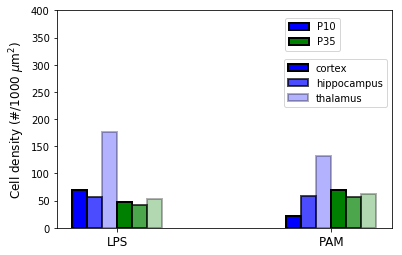

In [404]:
N = 2

fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.07         # the width of the bars
p1 = ax.bar(ind, dens[[0,6]], width, color='b', bottom=0, edgecolor='k', linewidth=2)
p2 = ax.bar(ind + width, dens[[1,7]], width, color='b', bottom=0, edgecolor='k', linewidth=2, alpha=0.7)
p3 = ax.bar(ind + 2*width, dens[[2,8]], width, color='b', bottom=0, edgecolor='k', linewidth=2, alpha=0.3)

p4 = ax.bar(ind + 3*width, dens[[12,18]], width, color='g', bottom=0, edgecolor='k', linewidth=2)
p5 = ax.bar(ind + 4*width, dens[[13,19]], width, color='g', bottom=0, edgecolor='k', linewidth=2, alpha=0.7)
p6 = ax.bar(ind + 5*width, dens[[14,20]], width, color='g', bottom=0, edgecolor='k', linewidth=2, alpha=0.3)

ax.set_ylabel(r'Cell density (#/1000 $\mu$' + r'm$^2$)', fontsize=12)
ax.set_xticks(ind + 2.5*width)
ax.set_xticklabels(('LPS', 'PAM'), fontsize=12)
ax.set_ylim([0, 400])

legend1 = ax.legend((p1[0], p4[0]), ('P10', 'P35' ), loc=1, bbox_to_anchor=(0.86,0.99))
legend2 = ax.legend((p1[0], p2[0], p3[0]), ('cortex', 'hippocampus', 'thalamus'), loc=1, bbox_to_anchor=(1.0,0.8))
plt.gca().add_artist(legend1)

plt.show()

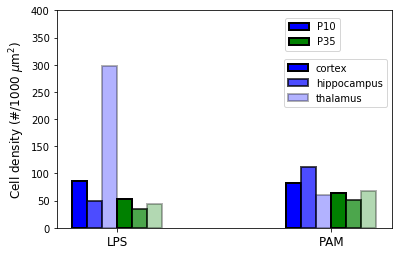

In [405]:
N = 2

fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.07         # the width of the bars
p1 = ax.bar(ind, dens[[3,9]], width, color='b', bottom=0, edgecolor='k', linewidth=2)
p2 = ax.bar(ind + width, dens[[4,10]], width, color='b', bottom=0, edgecolor='k', linewidth=2, alpha=0.7)
p3 = ax.bar(ind + 2*width, dens[[5,11]], width, color='b', bottom=0, edgecolor='k', linewidth=2, alpha=0.3)

p4 = ax.bar(ind + 3*width, dens[[15,21]], width, color='g', bottom=0, edgecolor='k', linewidth=2)
p5 = ax.bar(ind + 4*width, dens[[16,22]], width, color='g', bottom=0, edgecolor='k', linewidth=2, alpha=0.7)
p6 = ax.bar(ind + 5*width, dens[[17,23]], width, color='g', bottom=0, edgecolor='k', linewidth=2, alpha=0.3)

ax.set_ylabel(r'Cell density (#/1000 $\mu$' + r'm$^2$)', fontsize=12)
ax.set_xticks(ind + 2.5*width)
ax.set_xticklabels(('LPS', 'PAM'), fontsize=12)
ax.set_ylim([0, 400])

legend1 = ax.legend((p1[0], p4[0]), ('P10', 'P35' ), loc=1, bbox_to_anchor=(0.86,0.99))
legend2 = ax.legend((p1[0], p2[0], p3[0]), ('cortex', 'hippocampus', 'thalamus'), loc=1, bbox_to_anchor=(1.0,0.8))
plt.gca().add_artist(legend1)

plt.show()

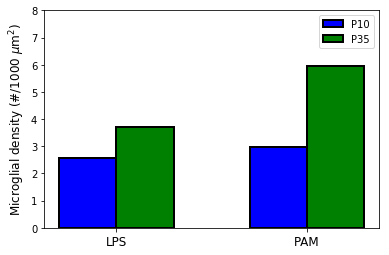

In [412]:
N = 2

fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.3         # the width of the bars
p1 = ax.bar(ind, dens[[0,2]], width, color='b', bottom=0, edgecolor='k', linewidth=2)
p2 = ax.bar(ind + width, dens[[4,6]], width, color='g', bottom=0, edgecolor='k', linewidth=2)

ax.set_ylabel(r'Microglial density (#/1000 $\mu$' + r'm$^2$)', fontsize=12)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('LPS', 'PAM'), fontsize=12)
ax.set_ylim([0, 8])

ax.legend((p1[0], p2[0]), ('P10', 'P35'))

plt.show()

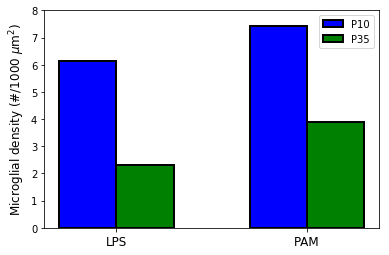

In [341]:
N = 2

fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.3         # the width of the bars
p1 = ax.bar(ind, dens[[1,3]], width, color='b', bottom=0, edgecolor='k', linewidth=2)
p2 = ax.bar(ind + width, dens[[5,7]], width, color='g', bottom=0, edgecolor='k', linewidth=2)

ax.set_ylabel(r'Microglial density (#/1000 $\mu$' + r'm$^2$)', fontsize=12)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('LPS', 'PAM'), fontsize=12)
ax.set_ylim([0, 8])

ax.legend((p1[0], p2[0]), ('P10', 'P35'))

plt.show()

In [110]:
mPAMR, bins = np.histogram(mglias[(mglias['hemisphere']=='R') & (mglias['Injury']=='PAM')]['total_branches'],
                           bins=np.linspace(0, 30, 16))

mPAML, bins = np.histogram(mglias[(mglias['hemisphere']=='L') & (mglias['Injury']=='PAM')]['total_branches'],
                           bins=np.linspace(0, 30, 16))

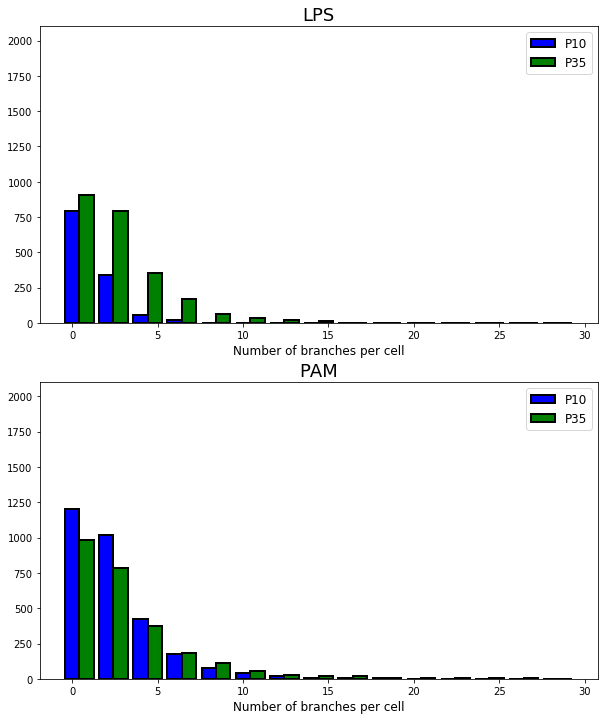

In [17]:
bins = np.linspace(0, 30, 16)
N = bins.shape[0]

fig, axes = plt.subplots(nrows=2, figsize=(10,12))

ind = np.arange(N-1)    # the x locations for the groups
width = 0.84       # the width of the bars
counter = 0

for ax in axes:
    mR, bins = np.histogram(mglias[(mglias['Age']=='P10') & (mglias['hemisphere']=='R') & (mglias['Injury']==types[counter])]['total_branches'],
                               bins=np.linspace(0, 30, 16))

    mL, bins = np.histogram(mglias[(mglias['Age']=='P35') & (mglias['hemisphere']=='R') & (mglias['Injury']==types[counter])]['total_branches'],
                               bins=np.linspace(0, 30, 16))

    
    p1 = ax.bar(ind*2, mR, width, color='b', bottom=0, edgecolor='k', linewidth=2)
    p2 = ax.bar(ind*2 + width, mL, width, color='g', bottom=0, edgecolor='k', linewidth=2)

    ax.set_title(types[counter], fontsize=18)
    ax.set_xlabel('Number of branches per cell', fontsize=12)
    #ax.set_xticks(ind + width / 2)
    #ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
    ax.set_ylim([0, 2100])
    
    ax.legend((p1[0], p2[0]), ('P10', 'P35'), prop={'size': 12})
    
    counter = counter + 1

plt.show()

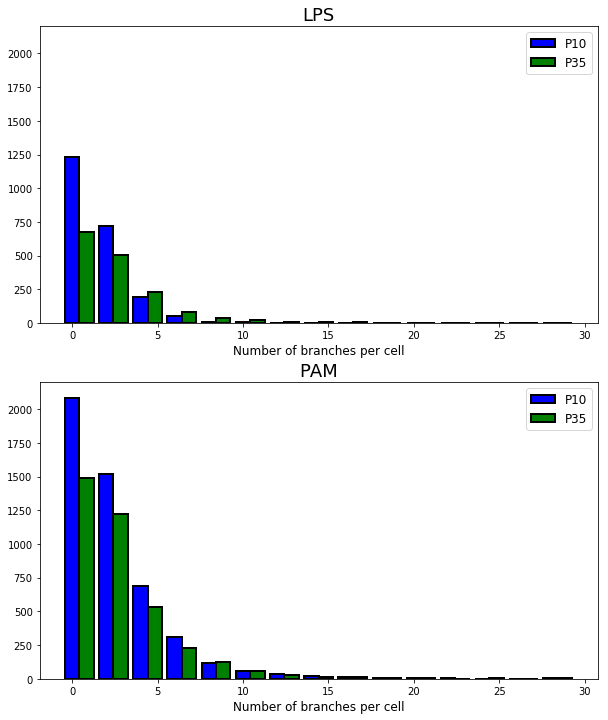

In [19]:
bins = np.linspace(0, 30, 16)
N = bins.shape[0]

fig, axes = plt.subplots(nrows=2, figsize=(10,12))

ind = np.arange(N-1)    # the x locations for the groups
width = 0.84       # the width of the bars
counter = 0

for ax in axes:
    mR, bins = np.histogram(mglias[(mglias['Age']=='P10') & (mglias['hemisphere']=='L') & (mglias['Injury']==types[counter])]['total_branches'],
                               bins=np.linspace(0, 30, 16))

    mL, bins = np.histogram(mglias[(mglias['Age']=='P35') & (mglias['hemisphere']=='L') & (mglias['Injury']==types[counter])]['total_branches'],
                               bins=np.linspace(0, 30, 16))

    
    p1 = ax.bar(ind*2, mR, width, color='b', bottom=0, edgecolor='k', linewidth=2)
    p2 = ax.bar(ind*2 + width, mL, width, color='g', bottom=0, edgecolor='k', linewidth=2)

    ax.set_title(types[counter], fontsize=18)
    ax.set_xlabel('Number of branches per cell', fontsize=12)
    #ax.set_xticks(ind + width / 2)
    #ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
    ax.set_ylim([0, 2200])
    
    ax.legend((p1[0], p2[0]), ('P10', 'P35'), prop={'size': 12})
    
    counter = counter + 1

plt.show()

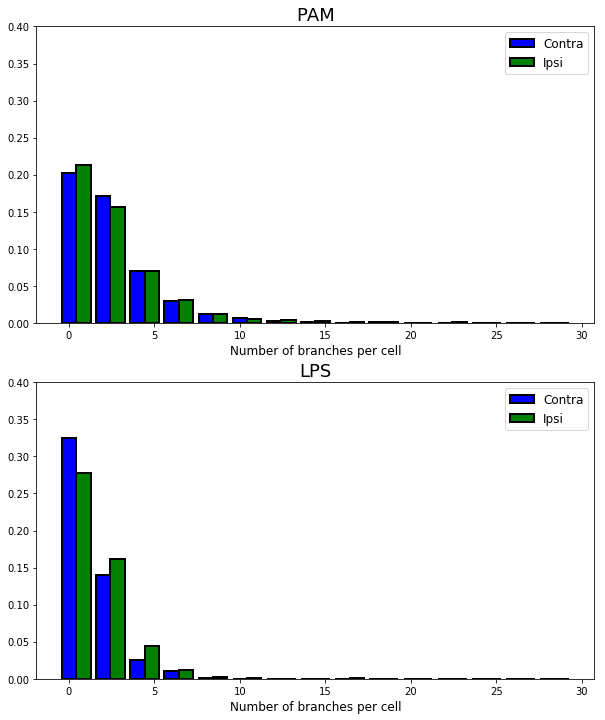

In [9]:
bins = np.linspace(0, 30, 16)
N = bins.shape[0]

fig, axes = plt.subplots(nrows=2, figsize=(10,12))

ind = np.arange(N-1)    # the x locations for the groups
width = 0.84       # the width of the bars
counter = 0

for ax in axes:
    mR, bins = np.histogram(mglias[(mglias['hemisphere']=='R') & (mglias['Injury']==types[counter])]['total_branches'],
                               bins=np.linspace(0, 30, 16), normed=True)

    mL, bins = np.histogram(mglias[(mglias['hemisphere']=='L') & (mglias['Injury']==types[counter])]['total_branches'],
                               bins=np.linspace(0, 30, 16), normed=True)

    
    p1 = ax.bar(ind*2, mR, width, color='b', bottom=0, edgecolor='k', linewidth=2)
    p2 = ax.bar(ind*2 + width, mL, width, color='g', bottom=0, edgecolor='k', linewidth=2)

    ax.set_title(types[counter], fontsize=18)
    ax.set_xlabel('Number of branches per cell', fontsize=12)
    #ax.set_xticks(ind + width / 2)
    #ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
    ax.set_ylim([0, 0.4])
    
    ax.legend((p1[0], p2[0]), ('Contra', 'Ipsi'), prop={'size': 12})
    
    counter = counter + 1

plt.show()

In [115]:
mPAML.shape

(15,)

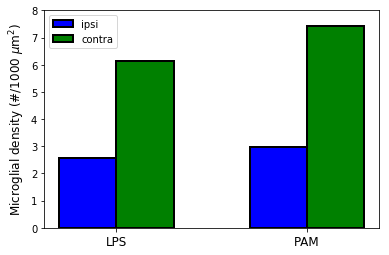

In [7]:
N = 2

fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.3         # the width of the bars
p1 = ax.bar(ind, dens[[0,2]], width, color='b', bottom=0, edgecolor='k', linewidth=2)
p2 = ax.bar(ind + width, dens[[1,3]], width, color='g', bottom=0, edgecolor='k', linewidth=2)

ax.set_ylabel(r'Microglial density (#/1000 $\mu$' + r'm$^2$)', fontsize=12)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('LPS', 'PAM'), fontsize=12)
ax.set_ylim([0, 8])

ax.legend((p1[0], p2[0]), ('ipsi', 'contra'))

plt.show()

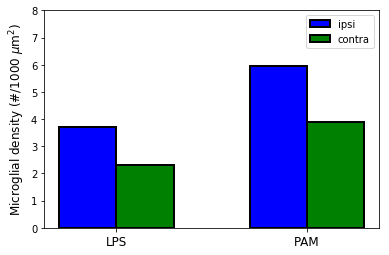

In [8]:
N = 2

fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.3         # the width of the bars
p1 = ax.bar(ind, dens[[4,6]], width, color='b', bottom=0, edgecolor='k', linewidth=2)
p2 = ax.bar(ind + width, dens[[5,7]], width, color='g', bottom=0, edgecolor='k', linewidth=2)

ax.set_ylabel(r'Microglial density (#/1000 $\mu$' + r'm$^2$)', fontsize=12)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('LPS', 'PAM'), fontsize=12)
ax.set_ylim([0, 8])

ax.legend((p1[0], p2[0]), ('ipsi', 'contra'))

plt.show()

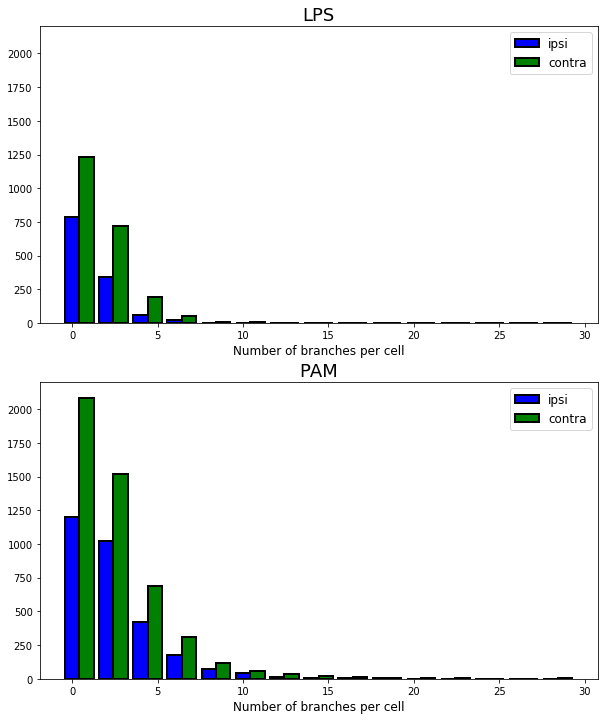

In [9]:
bins = np.linspace(0, 30, 16)
N = bins.shape[0]

fig, axes = plt.subplots(nrows=2, figsize=(10,12))

ind = np.arange(N-1)    # the x locations for the groups
width = 0.84       # the width of the bars
counter = 0

for ax in axes:
   mR, bins = np.histogram(mglias[(mglias['Age']=='P10') & (mglias['hemisphere']=='R') & (mglias['Injury']==types[counter])]['total_branches'],
                              bins=np.linspace(0, 30, 16))

   mL, bins = np.histogram(mglias[(mglias['Age']=='P10') & (mglias['hemisphere']=='L') & (mglias['Injury']==types[counter])]['total_branches'],
                              bins=np.linspace(0, 30, 16))


   p1 = ax.bar(ind*2, mR, width, color='b', bottom=0, edgecolor='k', linewidth=2)
   p2 = ax.bar(ind*2 + width, mL, width, color='g', bottom=0, edgecolor='k', linewidth=2)

   ax.set_title(types[counter], fontsize=18)
   ax.set_xlabel('Number of branches per cell', fontsize=12)
   #ax.set_xticks(ind + width / 2)
   #ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
   ax.set_ylim([0, 2200])

   ax.legend((p1[0], p2[0]), ('ipsi', 'contra'), prop={'size': 12})

   counter = counter + 1

plt.show()

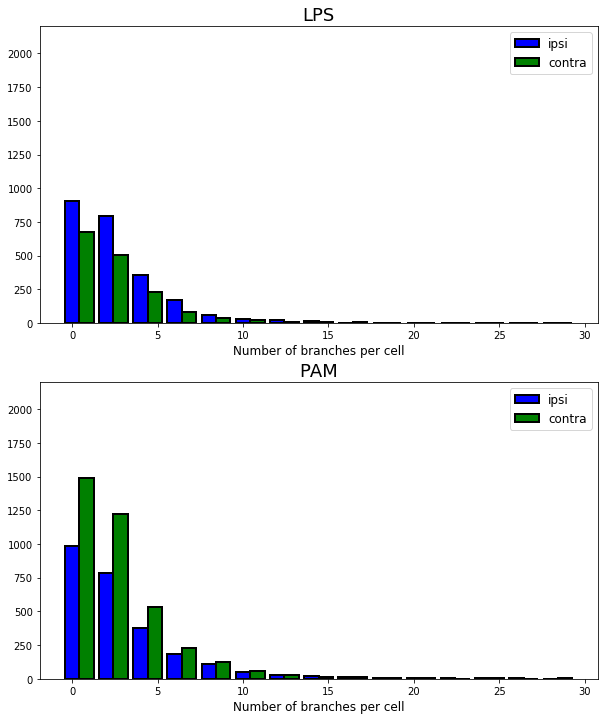

In [10]:
bins = np.linspace(0, 30, 16)
N = bins.shape[0]

fig, axes = plt.subplots(nrows=2, figsize=(10,12))

ind = np.arange(N-1)    # the x locations for the groups
width = 0.84       # the width of the bars
counter = 0

for ax in axes:
   mR, bins = np.histogram(mglias[(mglias['Age']=='P35') & (mglias['hemisphere']=='R') & (mglias['Injury']==types[counter])]['total_branches'],
                              bins=np.linspace(0, 30, 16))

   mL, bins = np.histogram(mglias[(mglias['Age']=='P35') & (mglias['hemisphere']=='L') & (mglias['Injury']==types[counter])]['total_branches'],
                              bins=np.linspace(0, 30, 16))


   p1 = ax.bar(ind*2, mR, width, color='b', bottom=0, edgecolor='k', linewidth=2)
   p2 = ax.bar(ind*2 + width, mL, width, color='g', bottom=0, edgecolor='k', linewidth=2)

   ax.set_title(types[counter], fontsize=18)
   ax.set_xlabel('Number of branches per cell', fontsize=12)
   #ax.set_xticks(ind + width / 2)
   #ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
   ax.set_ylim([0, 2200])

   ax.legend((p1[0], p2[0]), ('ipsi', 'contra'), prop={'size': 12})

   counter = counter + 1

plt.show()